## Alvan's Model: Deconvolution
$$Z=BY+(1-B)U$$
where $B,Y,U$ are independent. Then,
$$P(Z\leq z)=P(Z\leq z | B=1)P(B=1)+P(Z\leq z|B=0)P(B=0)=\frac{1}{2}\left(P(Z\leq z | B=1)+P(Z\leq z | B=0)\right)=\frac{1}{2}\left(P(Y\leq z | B=1)+P(U\leq z | B=0)\right)=\frac{1}{2}(P(Y\leq z)+P(U\leq z))$$
$$2P(Z\leq z)=P(Y\leq z)+P(U\leq z)$$
So, we have the CDF:
$$P(Y\leq y)=2P(Z\leq y)-P(U\leq y)$$
We can use the ECDF to estimate $P(Z\leq y)$ and we know $P(Y\leq y)$ for various $y$, so this gives a consistent estimator for $P(Y\leq y)$. Recall the $n$ of Alvan is $2\cdot $ the $n$ of Warner's. Similarly, we can use $f_{KDE}(z)$ to get a KDE-derived estimate for $f_{Y}(y)$. Then,
$$\hat{\theta}(y)=\frac{2}{n}\sum_{i=1}^{n}I(Z_i\leq y)-P(U\leq y)$$
$$\text{Var}(\hat{\theta}(y))=\frac{4}{n}P(Z\leq y)(1-P(Z\leq y))$$
$$\text{max}\text{Var}(\hat{\theta}(y))=\frac{4}{n}(0.5)(1-0.5)=\frac{1}{n}$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

/var/folders/fg/n7d57ft153bf46npr6w6jjxr0000gn/T/ipykernel_85816/3854569243.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
np.random.seed(0)

In [3]:
from scipy import stats
from scipy.signal import convolve

In [4]:
import multiprocess as mp

In [36]:
def cdfU(u):
  if u < -1: return 0.
  elif u > 1: return 1.
  else: return (u+1.)/2.

cdfU = np.vectorize(cdfU)

def box_sim(Y, r=1, n=100, m=100):
  Ys = Y.rvs(size=n)
  Us = (stats.uniform.rvs(size=n*r)-0.5)*2
  Zs = np.concatenate([Ys, Us])

  Z_sample = np.random.choice(Zs, replace=True, size=m)

  est_cdfY = np.vectorize(lambda y : (r+1)*np.mean(Z_sample < y) - r*cdfU(y))
  return est_cdfY

In [37]:
Y = stats.norm(loc=0, scale=1)

In [39]:
%%time
n = int(1e3)
B = int(1e2)
m = int(1e6)
r = 1
Ys_plot = np.linspace(-3, 3, 100)
pool = mp.Pool(processes=mp.cpu_count())
res = np.array(pool.map(lambda _: box_sim(Y, r=r, n=n, m=m)(Ys_plot), range(B)))

CPU times: user 24.4 ms, sys: 48.7 ms, total: 73.1 ms
Wall time: 4.71 s


\begin{align*}
    \text{Var}(\hat{\theta}(y))=&\mathbb{E}[\text{Var}(\hat{\theta}(y)|Z_1,\dots,Z_m)]+\text{Var}(\mathbb{E}[\hat{\theta}(y)|Z_1,\dots,Z_{2n}])\\
    =&\frac{1}{m}\left(2\left(2-\frac{1}{n}\right)(P(Y\leq y)+P(U\leq y))-\left(1-\frac{1}{n}\right)(P(Y\leq y)+P(U\leq y))^2\right)\\
    &+\frac{1}{n}(P(Y\leq y)(1-P(Y\leq y))+P(U\leq y)(1-P(U\leq y)))
\end{align*}

In [21]:
Yc, Uc = Y.cdf(Ys_plot), cdfU(Ys_plot)

r = 1
var_theo_EV = (1/m)*(((r+1)-(1/n))*(Yc+r*Uc) - (1-(1/n))*(Yc**2)-2*r*Yc*Uc-r*(r-(1/n))*(Uc**2))
var_theo_VE = (1/n)*(Yc*(1-Yc)+r*Uc*(1-Uc))

# var_theo_EV = (1/m)*(2*((r+1)-(1/n))*(Yc+r*Uc) - (1-(1/n))*((Yc+Uc)**2))
# var_theo_VE = (1/n)*(Yc*(1-Yc)+Uc*(1-Uc))
var_theo = var_theo_EV + var_theo_VE

var_sample = np.std(res, axis=0, ddof=1)**2

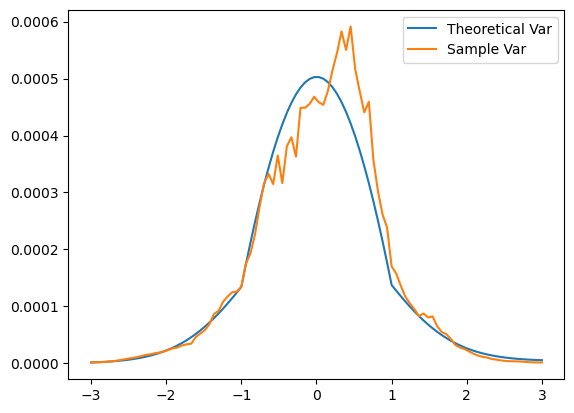

In [22]:
plt.plot(Ys_plot, var_theo, label='Theoretical Var')
plt.plot(Ys_plot, var_sample, label='Sample Var')
# plt.plot(Ys_plot, Yc)
plt.legend()

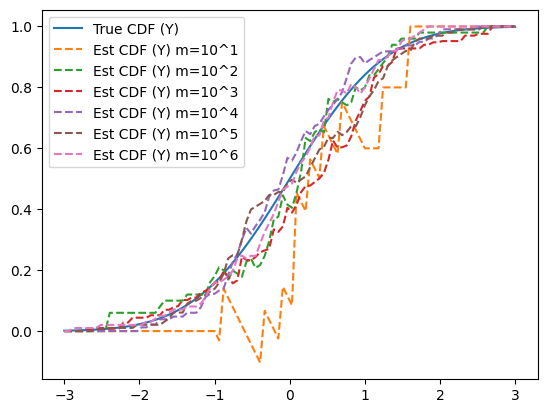

In [48]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,7):
  est_cdfY = box_sim(Y, n=int(1e2), m=int(10**k))
  plt.plot(Ys_plot, est_cdfY(Ys_plot), label=f'Est CDF (Y) m=10^{k}', linestyle='--')

plt.legend()

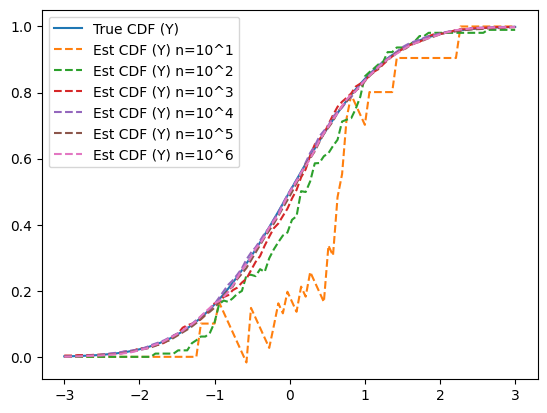

In [46]:
plt.plot(Ys_plot, Y.cdf(Ys_plot), label='True CDF (Y)', linestyle='-')

for k in range(1,7):
  est_cdfY = box_sim(Y, n=int(10**k), m=int(10**4))
  plt.plot(Ys_plot, est_cdfY(Ys_plot), label=f'Est CDF (Y) n=10^{k}', linestyle='--')

plt.legend()

## Werner's Non-Optional Deconvolution
$$P(Z\leq z)=\int_{y} P(Y\leq y)P(U= z-y)dy=\frac{1}{2}\int_{z-1}^{z+1}P(Y\leq y)dy$$
$$\frac{d}{dz}P(Z\leq z)=\frac{1}{2}\left(P(Y\leq z+1)-P(Y\leq z-1)\right)$$
$$P(z-1\leq Y\leq z+1)=2\cdot \frac{d}{dz}P(Z\leq z)$$
$$P(z-2\leq Y\leq z)=2\cdot \frac{d}{dz}P(Z\leq z-1)$$
$$P(Y\leq y)=\sum_{k=1}^{\infty} 2\cdot \frac{d}{dz}P(Z\leq z)\biggr\rvert_{z=y-2k+1}$$
$$f_{Y}(y)=2\sum_{k=1}^{\infty}\frac{d}{dy}\left(\frac{d}{dz}P(Z\leq z)\biggr\rvert_{z=y-2k+1}\right)=2\sum_{k=1}^{\infty}\frac{d^2}{dz^2}P(Z\leq z)\biggr\rvert_{z=y-2k+1}$$
Let $f_{KDE}(z)$ be the kernel density estimation of $Z$ from the sample. Using the finite element method or a smoothing spline, we estimate $g(z)\approx \frac{d}{dz}f_{KDE}(z)$. Then,
$$F_{Y}(y)=2\sum_{k=1}^{\infty}f_{KDE}(y-2k+1)$$
$$f_{Y}(y)=2\sum_{k=1}^{\infty}g(y-2k+1)$$